# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (122.5, 123.75)
LAT_LIMITS = (-14.3, -13.3)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2024-05-01T00:00:00", "2024-06-01T00:00:00"]

crop_app = 'browse_basin_winter24'

# # Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
# # sudo mount -t drvfs 'D:' /mnt/d
# alldata_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'all')
# cropped_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'browse')
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [3]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

In [4]:
# ### Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [5]:
# # Move the new files to another folder
# move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     shutil.move(mf, os.path.join(cropped_dir, f_name))

In [6]:
# # Load the data
# ds = himawari.process_sst_series(cropped_dir, time_lims, ll_box, file_app=crop_app)
# ds

In [8]:
### Optional: save joined DS and delete individual cropped files
# ds.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))#.sel(time=slice(time_lims[0], time_lims[1]))

### Uncomment to delete individual cropped files
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     os.remove(os.path.join(cropped_dir, f_name))

In [9]:
fig, ax = plots.plot_gradients(ds.isel(time=24*14), sg_names=['dTdx','dTdy'])

ValueError: Dimensions {'time'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({})

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [13]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(59, 'm').astype('timedelta64[ns]')

# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=os.path.join(cropped_dir, f'{crop_app}_fits_1h.nc'), callback='off', coverage=0.8)

Running GP optimization


In [14]:
### Load the results
ds_results = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_fits_1h.nc'))
ds_results.close()
ds_results

<xarray.Dataset> Size: 62kB
Dimensions:    (time: 707)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2024-06-01 ... 2024-07-01
Data variables:
    sigma_u    (time) float64 6kB ...
    l_u        (time) float64 6kB ...
    tau_u      (time) float64 6kB ...
    sigma_S    (time) float64 6kB ...
    l_S        (time) float64 6kB ...
    tau_S      (time) float64 6kB ...
    sigma_tau  (time) float64 6kB ...
    l_v        (time) float64 6kB ...
    sigma_v    (time) float64 6kB ...
    tau_v      (time) float64 6kB ...

In [11]:
# ## Use parameters to make predictions
# print("Calculating GP regression prediction")
# ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results)
# ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_predictions_1h.nc'))

### Load the data
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_predictions_1h.nc'))

In [22]:
ds_restrim = ds_results.copy()
ds_restrim = ds_restrim.dropna(dim='time')
ds_restrim = utils.clean_dataset(ds_restrim)
ds_restrim

<xarray.Dataset> Size: 59kB
Dimensions:    (time: 673)
Coordinates:
  * time       (time) datetime64[ns] 5kB 2024-06-01T11:00:00 ... 2024-07-01
Data variables:
    sigma_u    (time) float64 5kB 0.0907 0.09001 0.09013 ... 0.09027 0.08991
    l_u        (time) float64 5kB 2.993e+04 2.999e+04 ... 2.998e+04 2.986e+04
    tau_u      (time) float64 5kB 0.01 0.01 0.01 0.01001 ... 0.01 0.01 0.01 0.01
    sigma_S    (time) float64 5kB 3.021e-07 1.052e-05 ... 4.937e-06 6.569e-06
    l_S        (time) float64 5kB 1.991e+04 1.149e+04 ... 1.23e+04 2.604e+04
    tau_S      (time) float64 5kB 2.026e-07 5.451e-08 ... 2.572e-07 3.758e-07
    sigma_tau  (time) float64 5kB 0.01454 8.14e-05 ... 0.004908 0.006035
    l_v        (time) float64 5kB 2.993e+04 2.999e+04 ... 2.998e+04 2.986e+04
    sigma_v    (time) float64 5kB 0.0907 0.09001 0.09013 ... 0.09027 0.08991
    tau_v      (time) float64 5kB 0.01 0.01 0.01 0.01001 ... 0.01 0.01 0.01 0.01

In [16]:
# If you prefer to have nan instead of missing time steps
ds_full_hourly = utils.make_even_hourly(ds_full)
ds_restrim_hourly = utils.make_even_hourly(ds_restrim)

In [17]:
nanx = np.isnan(ds_full_hourly['mu_u'].isel(lon=10, lat=8))

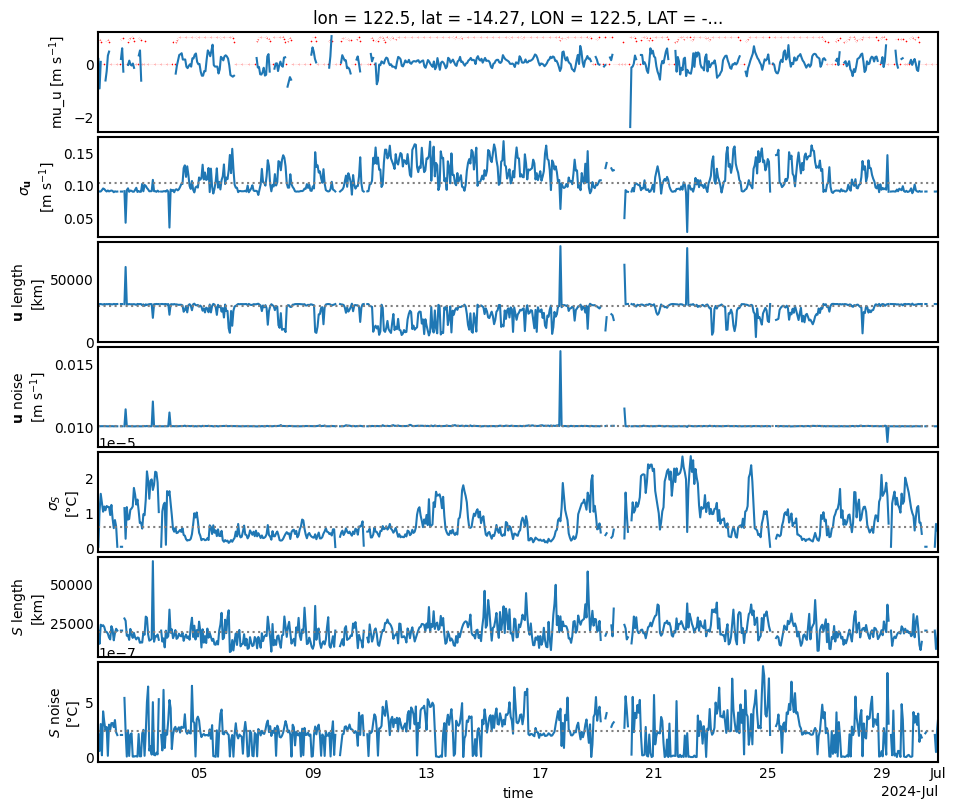

In [24]:
fig, ax = plots.plot_param_series(ds_restrim_hourly, ds_full_hourly)

In [25]:
## Make a dataset of the median param values
ds_res_median = ds_results.copy()
for var in ds_res_median.data_vars:
    ds_res_median[var].values = np.repeat(np.nanmedian(ds_restrim[var].where(~nanx).values), len(ds_results['time'].values))
ds_res_median.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_fits_1h_median.nc'))
ds_res_median

<xarray.Dataset> Size: 62kB
Dimensions:    (time: 707)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2024-06-01 ... 2024-07-01
Data variables:
    sigma_u    (time) float64 6kB 0.1097 0.1097 0.1097 ... 0.1097 0.1097 0.1097
    l_u        (time) float64 6kB 2.696e+04 2.696e+04 ... 2.696e+04 2.696e+04
    tau_u      (time) float64 6kB 0.01002 0.01002 0.01002 ... 0.01002 0.01002
    sigma_S    (time) float64 6kB 6.045e-06 6.045e-06 ... 6.045e-06 6.045e-06
    l_S        (time) float64 6kB 2.015e+04 2.015e+04 ... 2.015e+04 2.015e+04
    tau_S      (time) float64 6kB 2.621e-07 2.621e-07 ... 2.621e-07 2.621e-07
    sigma_tau  (time) float64 6kB 0.005115 0.005115 ... 0.005115 0.005115
    l_v        (time) float64 6kB 2.696e+04 2.696e+04 ... 2.696e+04 2.696e+04
    sigma_v    (time) float64 6kB 0.1097 0.1097 0.1097 ... 0.1097 0.1097 0.1097
    tau_v      (time) float64 6kB 0.01002 0.01002 0.01002 ... 0.01002 0.01002

In [26]:
def xarray_to_dict(ds):
    return {var: ds[var].values for var in ds.data_vars}

In [27]:
ds_median_dict = xarray_to_dict(ds_res_median.isel(time=120))
ds_median_dict

{'sigma_u': array(0.10971525),
 'l_u': array(26955.24359903),
 'tau_u': array(0.01001573),
 'sigma_S': array(6.04493076e-06),
 'l_S': array(20149.63737384),
 'tau_S': array(2.62084537e-07),
 'sigma_tau': array(0.00511527),
 'l_v': array(26955.24359903),
 'sigma_v': array(0.10971525),
 'tau_v': array(0.01001573)}

In [30]:
# ## Predict with median
# print("Calculating GP regression prediction")
# ds_pred_median = gpr.predict_series(ds, ds_median_dict, coverage=0.8)
# ds_pred_median.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_predictions_1h_median.nc'))
ds_pred_median = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_predictions_1h_median.nc'))

In [31]:
ds_median_hourly = utils.make_even_hourly(ds_pred_median)
ds_median_hourly

<xarray.Dataset> Size: 86MB
Dimensions:    (lon: 21, lat: 16, time: 2894)
Coordinates:
  * lon        (lon) float64 168B 122.5 122.6 122.7 122.7 ... 123.6 123.7 123.7
  * lat        (lat) float64 128B -14.27 -14.21 -14.15 ... -13.49 -13.43 -13.37
  * time       (time) datetime64[ns] 23kB 2024-06-02T10:00:00 ... 2024-09-30T...
    LON        (lat, lon) float64 3kB ...
    LAT        (lat, lon) float64 3kB ...
    X          (lat, lon) float64 3kB ...
    Y          (lat, lon) float64 3kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 8MB 28.4 28.38 28.39 ... 29.23 29.31
    dTdt       (time, lat, lon) float64 8MB -2.639e-05 -2.778e-05 ... -4.012e-06
    dTdx       (time, lat, lon) float64 8MB -3.947e-06 -1.459e-06 ... 1.214e-05
    dTdy       (time, lat, lon) float64 8MB 1.188e-05 nan ... -4.017e-06
    mu_u       (time, lat, lon) float64 8MB 0.106 0.1114 ... 0.6865 0.7285
    mu_v       (time, lat, lon) float64 8MB 0.3187 0.3201 ... -0.1219 -0.1304
    mu_S       (time, lat, lon) float64 8MB -2.303e-05 -2.429e-05 ... 6.174e-06
    std_u      (time, lat, lon) float64 8MB 0.1587 0.1468 ... 0.1395 0.1463
    std_v      (time, lat, lon) float64 8MB 0.1578 0.1488 ... 0.1505 0.1595
    std_S      (time, lat, lon) float64 8MB 2.052e-06 2.859e-06 ... 2.143e-06
    K_uv       (time, lat, lon) float64 8MB 0.005507 0.005634 ... -0.002401

In [32]:
ds_full_hourly = ds_full_hourly.where(ds_median_hourly.time)

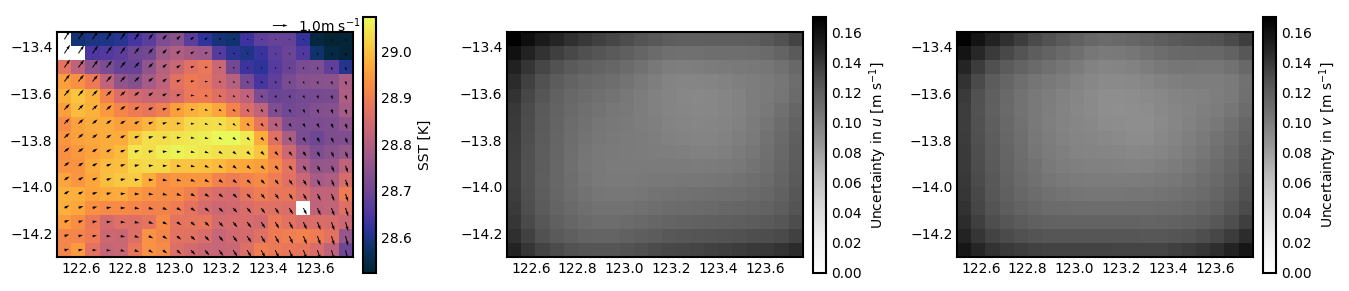

In [33]:
fig, ax = plots.plot_prediction(ds_full_hourly.isel(time=48), qv_scale=20, qk_size=1.)

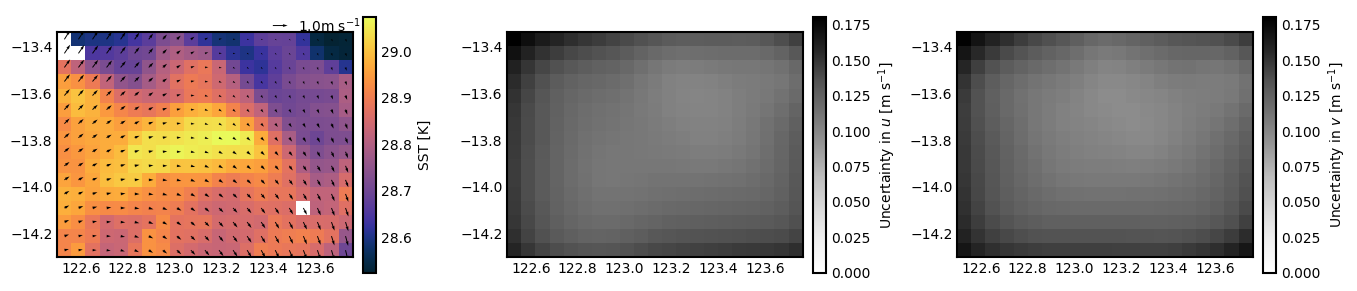

In [34]:
fig, ax = plots.plot_prediction(ds_median_hourly.isel(time=48), qv_scale=20, qk_size=1.)

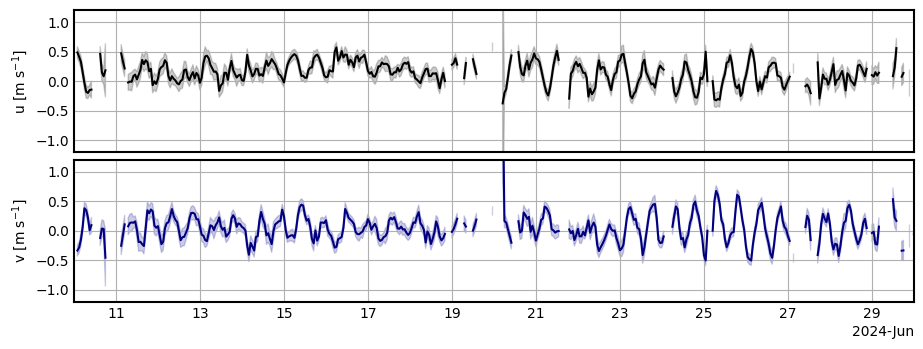

In [40]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=123.3744, lat_pt=-13.74942)
for x in ax:
    x.set_ylim(-1.21,1.21)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(40,'D'), np.datetime64(time_lims[0]) + np.timedelta64(60,'D'))

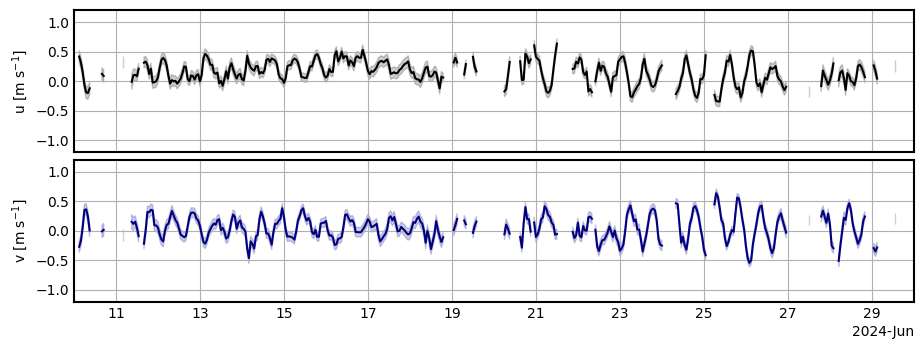

In [41]:
fig, ax = plots.plot_timeseries(ds_median_hourly, lon_pt=123.3744, lat_pt=-13.74942)
for x in ax:
    x.set_ylim(-1.21,1.21)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(40,'D'), np.datetime64(time_lims[0]) + np.timedelta64(60,'D'))

## Some analysis

In [ ]:
import os
import pIMOS.utils.catalogue as pcat

# Load the DWR data
exp = 'Shell'
moor = 'DWR'
exp_base = os.path.join(base_dir, 'Industry', exp, 'data', 'moored_instrument_data')

cat = pcat.get_pimos_catalogue(exp_base, is_moored=True)

# Load the most recent DWR file
ds_dwr = xr.open_dataset(cat['nc_path'].loc[cat['Group']==moor].values[-1], decode_times=True)
ds_dwr

INITIALISING pIMOS


/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/dolfyn/io/api.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Need to update dolfyn to version 1
pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp
Looking for pimos_v1.1.1 within /mnt/d/Work_backup/C_drive/Large_Data/Industry/Shell/data/moored_instrument_data
.... pimos_v1.1.1 found
FV01


<xarray.Dataset> Size: 4MB
Dimensions:               (time: 26455)
Coordinates:
  * time                  (time) datetime64[ns] 212kB 2024-01-31T10:00:00 ......
    lat_nom               float64 8B ...
    lon_nom               float64 8B ...
    z_nom                 float64 8B ...
Data variables: (12/23)
    current_speed         (time) float32 106kB ...
    qc_current_speed      (time) float64 212kB ...
    current_direction     (time) float32 106kB ...
    qc_current_direction  (time) float64 212kB ...
    SigmaCurSpd           (time) float32 106kB ...
    qc_SigmaCurSpd        (time) float64 212kB ...
    ...                    ...
    qc_MeanCurVertComp    (time) float64 212kB ...
    SigmaCurVertComp      (time) float32 106kB ...
    qc_SigmaCurVertComp   (time) float64 212kB ...
    east_vel              (time) float32 106kB ...
    north_vel             (time) float32 106kB ...
    qc_velocity           (time) float32 106kB ...
Attributes: (12/35)
    title:                           Measured data parsed from an RPS data file.
    institution:                     The University of Western Australia
    institution_division:            Ocean Dynamics
    source:                          pIMOS RPS
    project:                         Prelude
    history:                         2024-08-12 14:16:45 [AFS] 2024-08-12 14:...
    ...                              ...
    nominal_instrument_height_asb:   250.35
    nominal_instrument_orientation:  
    timezone:                        
    process_level:                   1
    is_profile_data:                 0
    pimos_nickname:                  DWR

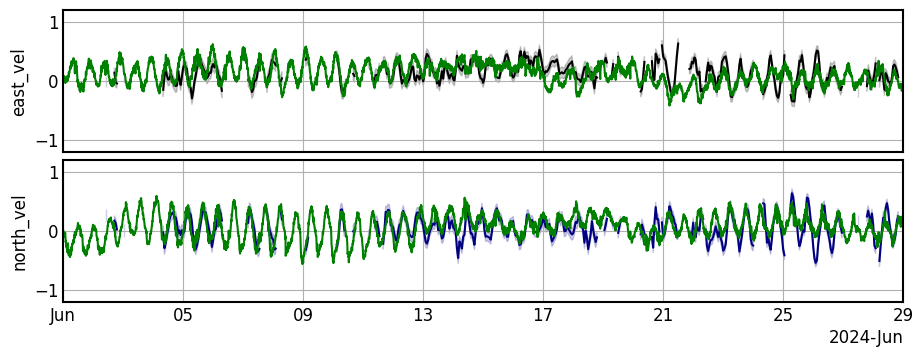

In [ ]:
fig, ax = plots.plot_timeseries(ds_median_hourly, lon_pt=123.3744, lat_pt=-13.74942)

ds_dwr['east_vel'].plot(ax=ax[0], c='g')
ds_dwr['north_vel'].plot(ax=ax[1], c='g')

for x in ax:
    x.set_ylim(-1.21,1.21)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))
    x.set_title('')
    x.set_xlabel('')
_=ax[0].set_xticklabels([])

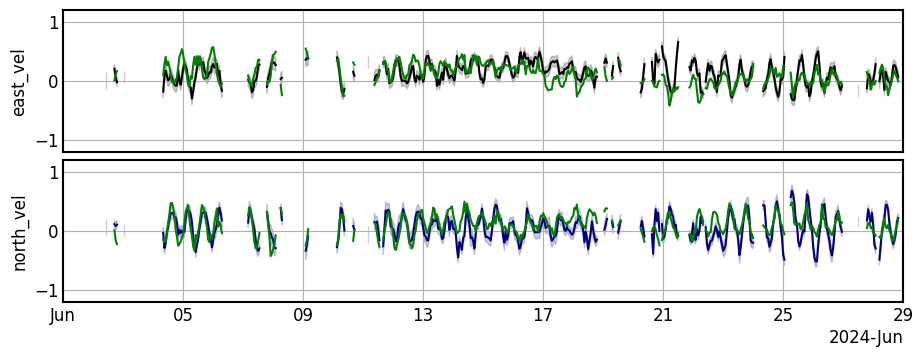

In [ ]:
dwr_east_int = ds_dwr['east_vel'].interp(time=ds_median_hourly['time'], method='nearest')
dwr_north_int = ds_dwr['north_vel'].interp(time=ds_median_hourly['time'], method='nearest')

fig, ax = plots.plot_timeseries(ds_median_hourly, lon_pt=123.3744, lat_pt=-13.74942)

pred_nan = ~np.isnan(ds_median_hourly['mu_u'].sel(lon=123.3744, lat=-13.74942, method='nearest'))
dwr_east_int.where(pred_nan).plot(ax=ax[0], c='g')
dwr_north_int.where(pred_nan).plot(ax=ax[1], c='g')

for x in ax:
    x.set_ylim(-1.21,1.21)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))
    x.set_title('')
    x.set_xlabel('')
_=ax[0].set_xticklabels([])

In [ ]:
def rmse(a, b):
    return np.sqrt(np.nanmean((a - b)**2))

print('RMSE east vel: ', rmse(ds_median_hourly['mu_u'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(pred_nan), dwr_east_int.where(pred_nan)))
print('RMSE north vel: ', rmse(ds_median_hourly['mu_v'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(pred_nan), dwr_north_int.where(pred_nan)))

print('Corr east vel: ', np.corrcoef(ds_median_hourly['mu_u'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(pred_nan, drop=True), dwr_east_int.where(pred_nan, drop=True))[0,1])
print('Corr north vel: ', np.corrcoef(ds_median_hourly['mu_v'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(pred_nan, drop=True), dwr_north_int.where(pred_nan, drop=True))[0,1])

RMSE east vel:  0.18961730121977183
RMSE north vel:  0.19120341392369505
Corr east vel:  0.46033739665686096
Corr north vel:  0.5881282964732862


In [ ]:
import pandas as pd
from wootils.filters import check_spacing, filter1d_xr

# Filter the SST inversion data
print(check_spacing(ds_full['time'].values))

# Remove bad fits
ds_full = ds_full.where(np.abs(ds_full['mu_u']) < 1.2)
ds_full = ds_full.where(np.abs(ds_full['mu_v']) < 1.2)

# Fill missing time steps with zero
full_time = pd.date_range(start=ds_full['time'].min().values, end=ds_full['time'].max().values, freq='h')
ds_full = ds_full.reindex({'time': full_time}, fill_value=0)

print(check_spacing(ds_full['time'].values))

ds_full['mu_u_lp'] = filter1d_xr(ds_full['mu_u'].fillna(0), 60, 60, ftype='lowpass', axis=0)
ds_full['mu_v_lp'] = filter1d_xr(ds_full['mu_v'].fillna(0), 60, 60, ftype='lowpass', axis=0)

ModuleNotFoundError: No module named 'wootils'

In [ ]:
# Apply QC flags
ds_dwr['east_vel'][ds_dwr['qc_velocity']==1] = np.nan
ds_dwr['north_vel'][ds_dwr['qc_velocity']==1] = np.nan

# Filter the DWR data
print(check_spacing(ds_dwr['time'].values))

# Fill missing time steps with zero
full_time = pd.date_range(start=ds_dwr['time'].min().values, end=ds_dwr['time'].max().values, freq='10min')
ds_dwr = ds_dwr.reindex({'time': full_time}, fill_value=0)

print(check_spacing(ds_dwr['time'].values))

ds_dwr['east_vel_lp'] = filter1d_xr(ds_dwr['east_vel'].fillna(0), 60, 10, ftype='lowpass', axis=0)
ds_dwr['north_vel_lp'] = filter1d_xr(ds_dwr['north_vel'].fillna(0), 60, 10, ftype='lowpass', axis=0)

In [ ]:
ds_point = ds_full.sel(lon=123.3744, lat=-13.74942, method='nearest')

fig, ax = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'hspace':0.05})

ds_point['mu_u_lp'].plot(ax=ax[0], label='u velocity', c='k')
ds_dwr['east_vel_lp'].plot(ax=ax[0], c='g')

ds_point['mu_v_lp'].plot(ax=ax[1], label='v velocity', c='navy')
ds_dwr['north_vel_lp'].plot(ax=ax[1], c='g')

for x in ax:
    x.set_xlabel('')
    x.set_title('')
    x.set_ylim(-0.49, 0.49)
    x.grid()
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))

ax[0].set_xticklabels([])
ax[0].set_ylabel('$\overline{u}$ [m s$^{-1}$]')
ax[1].set_ylabel('$\overline{v}$ [m s$^{-1}$]')

In [ ]:
# Load some validation data
s

In [ ]:
# from IPython.display import HTML
# %matplotlib notebook

ani = plots.plot_prediction_animation(ds_full, qv_scale=20)
ani.save(f'{crop_app}_animation_full.mp4')
# HTML(ani.to_jshtml())

In [ ]:
ani = plots.plot_prediction_animation(ds_full, qv_scale=4, u_name='mu_u_lp', v_name='mu_v_lp', anim_interval=42)
ani.save(f'{crop_app}_animation_lp60hr.mp4')